# Notes on Diffusion Models

In this notebook, I will give an introduction to the mathematical theory behind diffusion models. I will also show how to build some diffusion models using `tensorflow`, and I will apply those models to some toy datasets. The goal here is to be very straigthforward and self-contained, giving simple examples to build intuition.

The idea behind diffusion models is a simple one: we take data from an unknown distribution and apply transformations to it until it seems that it came from a simple known distribution. Then, we build a machine learning model that learns to reverse the process, i.e., the model takes data from the simple and known distribution and transforms it to data that seems to come from the original data distribution. In this way, the model learns the true data distribution, and we can use it to generate samples that resemble the real ones.

## 1. Forward diffusion process

### 1.1 Theory

Let $\bm x_0$ be a data point sampled from an unknown (and probably very complicated) distribution. We want to transform it to a sample that seems to come from a simple and known distribution, let's say, from a Gaussian distribution. 

To build intuition, we can think of the sample as representing the position vector in $\mathbb{R}^3$ of a gas molecule. Let's then borrow some ideas from _statistical physics_. The data distribution from which $\bm x_0$ is sampled can be really complicated when the molecules have strong interactions among each other, which generally happens when they are close together. If they are _diffused_ in the medium, their positions are mostly random and not strongly correlated. The _entropy_ of the system is then maximized. Therefore, we can approximate the distribution of the diffused positions as a Gaussian, which maximizes entropy.

Thus, if we apply a _diffusion process_ to the sample $\bm x_0$, the resulting sample will be distributed according to a Gaussian distribution. We will use the intuition given by statistical physics to do so. In the diffusion of a gas molecule in a medium, the particle follows a trajectory such that its position vector changes from $\bm x_0$ to $\bm x_1$ at time $t=1$, from $\bm x_1$ to $\bm x_2$ at time $t=2$, all the way up to the final position $\bm x_T$ at time $t=T$. We can model this trajectory as a _Markov process_ $\bm x_0 \to \bm x_1, ..., \bm x_{T-1} \to \bm x_{T}$, with the conditional probability distribution of $\bm x_t$ given $\bm x_{t-1}$ being

$$q(\bm x_t| \bm x_{t-1}) = \mathcal{N}\left(\bm x_{t}; \sqrt{1 - \beta_t}\bm x_{t-1}, \beta_t\bm I\right).$$

That is, the probability distribution of $\bm x_t$ is a Gaussian whose mean is proportional to the previous sample $\bm x_{t-1}$ and whose covariance matrix is diagonal. The parameter $\beta_t$ is the "time-dependent" _variance_ of the Gaussian, also known as the _diffusion rate_,  and it can be scheduled to "add noise" to the samples at a proper pace. The joint probability of the whole process is thus given by

$$q(\bm x_{1:T}|\bm x_0) = \prod_{t=1}^Tq(\bm x_t| \bm x_{t-1}).$$

It turns out that we can generate a sample $\bm x_t$ at any time $t$ given only the initial sample $\bm x_0$. Consider a Gaussian variable

$$\bm x \sim \mathcal{N}\left(\bm \mu, \Sigma\right).$$

We can always express it as

$$\bm x = \bm \mu + A\bm z,$$

where $\bm z \sim \mathcal{N}(0, I)$ is a _standard Gaussian variable_ and $AA^T = \Sigma$. Therefore, we can express a sample in a diffusion process at time $t$ as

$$\bm x_t = \sqrt{1 - \beta_t}\bm x_{t-1} + \sqrt{\beta_t}\bm z,$$

where $\bm z \sim \mathcal{N}(0, I)$. The expression above allows us to iterate down to the first sample $\bm x_0$. To see that, let $\alpha_t = 1 - \beta_t$. Then,

$$\bm x_t = \sqrt{\alpha_t}\bm x_{t-1} + \sqrt{1 - \alpha_t}\bm z \\ = \sqrt{\alpha_t}\left(\sqrt{\alpha_{t-1}}\bm x_{t-2} + \sqrt{1 - \alpha_{t-1}}\bm z'\right) + \sqrt{1 - \alpha_t}\bm z \\ = \sqrt{\alpha_t \alpha_{t-1}} \bm x_{t-2} + \sqrt{\alpha_t(1-\alpha_{t-1})}\bm z' + \sqrt{1 - \alpha_t}\bm z.$$

Since the sum of two Gaussian variables with means $\bm \mu_1, \bm \mu_2$ and covariance matrices $\sigma_1^2I, \sigma_2^2I$ is another Gaussian variable with mean $\bm \mu_1 + \bm \mu_2$ and covariance matrix $(\sigma_1^2 + \sigma_2^2)I$, we have that the last two terms of the equation above are equal to a Gaussian variable with zero mean and covariance matrix 

$$(\alpha_t(1-\alpha_{t-1}) + (1 - \alpha_t))I = (1 - \alpha_t\alpha_{t-1})I.$$

Moreover, since for any random variable $\bm x$ and any constant $\gamma \in \mathbb{R}$ we have that $\text{Var}(\gamma \bm x) = \gamma^2\text{Var}(\bm x)$, we can finally write

$$\bm x_t = \sqrt{\alpha_t \alpha_{t-1}} \bm x_{t-2} + \sqrt{1 - \alpha_t\alpha_{t-1}}\bm z.$$

By proceeding with the iteration down to the first sample $\bm x_0$, we end-up with

$$\bm x_t = \sqrt{\bar \alpha_t}\bm x_0 + \sqrt{(1 - \bar \alpha_t)}\bm z,$$

where $\bm z \sim \mathcal{N}(0, I)$ and

$$\bar \alpha_t = \prod_{n = 1}^t\alpha_n = \prod_{n = 1}^t(1 - \beta_n)$$

Thus, we have that given an initial point $\bm x_0$, we can immediately generate the point $\bm x_t$ at time $t$ in a Gaussian diffusion process using the conditional probability distribution

$$q(\bm x_t| \bm x_0) = \mathcal{N}\left(\bm x_t; \sqrt{\bar \alpha_t}\bm x_0, (1 - \bar \alpha_t)I\right).$$

It is also clear that, if we choose a diffusion rate such that

$$\lim_{T \to \infty} \beta_T = 1,$$

we have that the final sample $\bm x_T$ is distributed according to $\mathcal{N}(0, I)$. That is, by performing the diffusion process long enough, we end up with a particle at a truly random position, with no memory of the past trajectory.


### 1.2 Example 

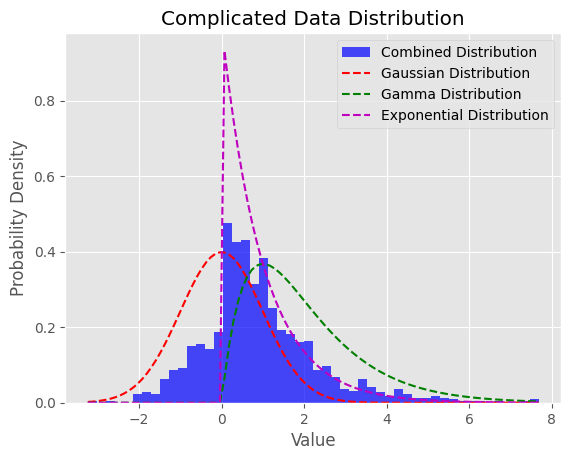

In [66]:
# Let's generate data from some complex distribution.
# To do so, we mix normal, gamma and exponential distributions.

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, expon

plt.style.use('ggplot')

np.random.seed(42)

num_samples = 1000

data_gaussian = np.random.normal(loc=0, scale=1, size=int(num_samples * 0.4))

data_gamma = np.random.gamma(shape=2, scale=1, size=int(num_samples * 0.3))

data_exponential = np.random.exponential(scale=1, size=int(num_samples * 0.3))

data_combined = np.concatenate([data_gaussian, data_gamma, data_exponential])

np.random.shuffle(data_combined)

plt.hist(data_combined, bins=50, density=True, alpha=0.7, color='b', label='Combined Distribution')

x = np.linspace(min(data_combined), max(data_combined), 100)
plt.plot(x, norm.pdf(x, loc=0, scale=1), 'r--', label='Gaussian Distribution')
plt.plot(x, gamma.pdf(x, a=2, scale=1), 'g--', label='Gamma Distribution')
plt.plot(x, expon.pdf(x, scale=1), 'm--', label='Exponential Distribution')

plt.title('Complicated Data Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


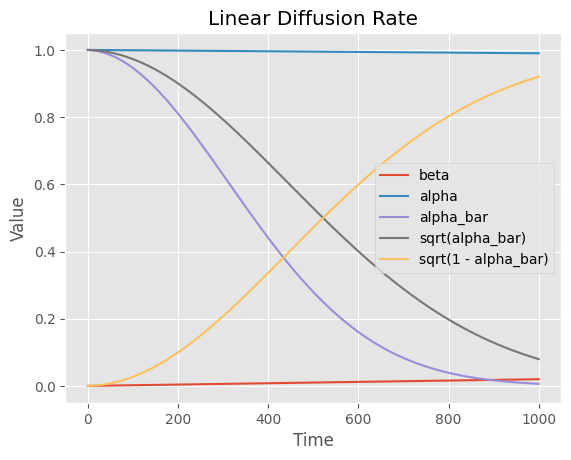

In [67]:
# Let's define the diffusion rate.

T = 1000

beta_t = lambda t: 1e-4 + (t/T) * (0.02 - 1e-4)
alpha_t = lambda t: np.sqrt(1 - beta_t(t))

ts = np.linspace(0, T, T)
betas = [beta_t(t) for t in ts]
alphas = [alpha_t(t) for t in ts]

prod_alphas = []
prod = 1
for x in alphas:
    prod *= x
    prod_alphas.append(prod)

sqrt_prod_alphas = [np.sqrt(x) for x in prod_alphas]
sqrt_prod_alphas_minus_1 = [1 - np.sqrt(x) for x in prod_alphas]

plt.title('Linear Diffusion Rate')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(ts, betas, label='beta')
plt.plot(ts, alphas, label='alpha')
plt.plot(ts, prod_alphas, label='alpha_bar')
plt.plot(ts, sqrt_prod_alphas, label='sqrt(alpha_bar)')
plt.plot(ts, sqrt_prod_alphas_minus_1, label='sqrt(1 - alpha_bar)')
plt.legend()

Text(0.5, 1.0, 'Diffusion trajectory of a sample')

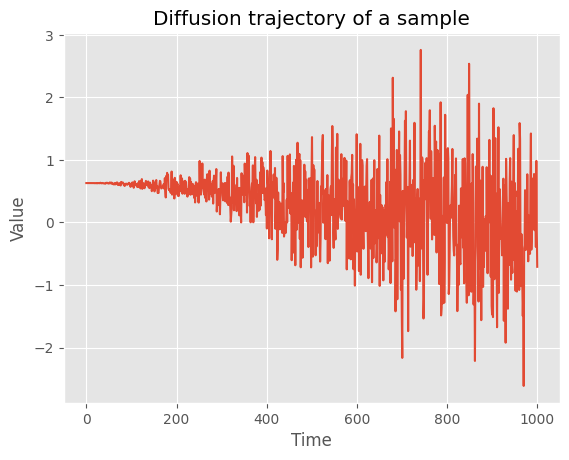

In [68]:
# Let's choose some samples of the complicated distribution and apply
# the diffusion process to them.

x0s = np.random.choice(data_combined, size=200)

def diffusion_process(x0: float, time: int) -> float:
    z = norm.rvs(loc=0, scale=1)
    xt = sqrt_prod_alphas[time] * x0 + sqrt_prod_alphas_minus_1[time] * z
    return xt

diffusion_process_results = []
for x0 in x0s:
    diffusion_process_results.append([diffusion_process(x0, t) for t in range(T)])

# Let's take a look at a single trajectory.
sample_trajectory = diffusion_process_results[100]
plt.plot(ts, sample_trajectory)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Diffusion trajectory of a sample')

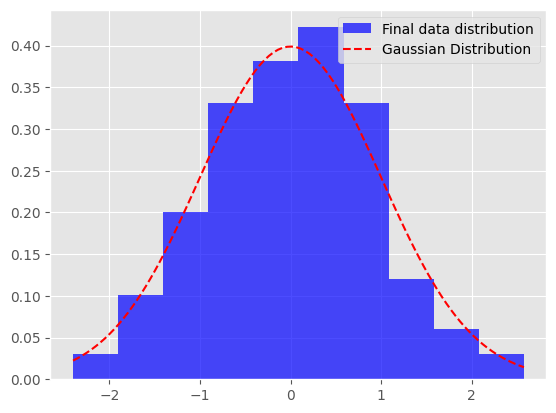

In [69]:
# Checking if the distribution of the final values are close to Gaussian.

final_samples = [x[-1] for x in diffusion_process_results]

x = np.linspace(min(final_samples), max(final_samples), 100)
plt.hist(final_samples, density=True, alpha=0.7, color='b', label='Final data distribution')
plt.plot(x, norm.pdf(x, loc=0, scale=1), 'r--', label='Gaussian Distribution')
plt.legend()

## Generative modelling

### 1.1 Undoing the diffusion process

Now that we learned how to transform a sample $\bm x_0$ from an unknown distribution into a Gaussian sample $\bm x_T$, we would like to learn the reverse process. That is, given a Gaussian sample $\bm x_T$, we would like to recover the sample $\bm x_0$. If we had the probability of observing $\bm x_{t-1}$ given $\bm x_t$, i.e., $q(\bm x_{t-1}|\bm x_t)$, we could use it stepwise and go all the way down to $t = 1$. From Bayes theorem, we have that

$$q(\bm x_{t-1}|\bm x_t) = \frac{q(\bm x_{t}|\bm x_{t-1})q(\bm x_{t-1})}{q(\bm x_t)}.$$

Although we know $q(\bm x_{t}|\bm x_{t-1})$, we don't know $q(\bm x_{t-1})$ or $q(\bm x_t)$. Moreover, since

$$q(\bm x_{t-1}) = \int q(\bm x_{t-1}|\bm x_0) q(\bm x_0)d\bm x_0, \\ q(\bm x_{t}) = \int q(\bm x_{t}|\bm x_0) q(\bm x_0)d\bm x_0,$$

it is clear that we would need knowledge of the original data distribution $q(\bm x_0)$ to compute such marginals. Since this distribution is _exactly_ what we want to find out, we can't go through that route.

What we can do is to try to approximate $q(\bm x_{t-1}|\bm x_t)$ the best we can. It is a well-known result from the theory of Markov chains that the reverse process, for a very small time step, follows the same distribution as the forward process. Thus, we know that $q(\bm x_{t-1}|\bm x_t)$ is a Gaussian, and we only need to find out its parameters. Therefore, we want to find the Gaussian distribution $p(\bm x_{t-1}|\bm x_t)$ that best approximates the real reverse process $q(\bm x_{t-1}|\bm x_t)$. We will use the data to estimate the parameters of the Gaussian distribution by means of a neural network parameterized by $\bm \theta$. If $\bm \mu_{\bm \theta}, \Sigma_{\bm \theta}$ are the estimated parameters of the Gaussian, we have that

$$p_{\bm \theta}(\bm x_{t-1}|\bm x_t) = \mathcal{N}\left(\bm x_{t-1}; \bm \mu_{\bm \theta}(\bm x_t, t), \Sigma_{\bm \theta}(\bm x_t, t)\right)$$